# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../data/4_best_predictions/"
FILE_PATTERN = "pa_transformer_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,Cc1ccccc1C(C)C,4.38,4.007513
1,Clc1nc(-c2ccccc2)nc2ccccc12,4.47,4.050775
2,Cc1ccc(O)c(C(=O)O)c1,2.78,2.781904
3,O=c1[nH]c(O)c(-c2ccccc2)[nH]1,0.46,0.569339
4,CN(C)CCN1c2ccccc2Sc2ccccc21,4.20,4.168931


In [8]:
compare_data.shape

(1894, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,16.529467,230.112729
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.167287,19.073198
762,O=C(Nc1ccccc1)c1c(O)[nH]c(=S)[nH]c1=O,0.14,2.296128,4.648886
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,2.511837,3.466436
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,7.293395,3.216266


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1186,CN(C(=O)CCCl)c1ccc(S(=O)(=O)N(C)C)cc1,0.98,0.980007,5.184000e-11
1089,CCC(CO)n1cnc2c(=N)[nH]cnc21,0.14,0.139901,9.725904e-09
1312,C#CCC(O)(c1ccc(F)cc1)c1cccnc1,1.78,1.780633,4.009422e-07
865,NC(=O)COc1ccccc1,0.76,0.759117,7.795654e-07
1227,C#CCOc1cc(OC(=O)N2CCCC2)c(Cl)cc1Cl,3.82,3.819049,9.036404e-07


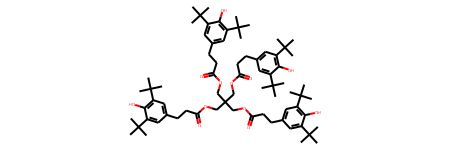

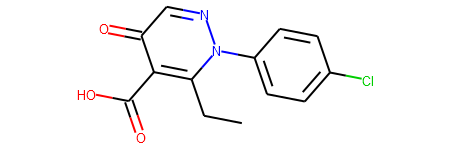

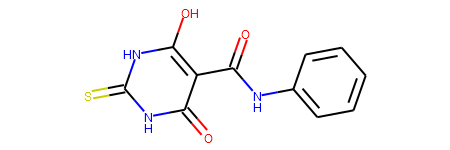

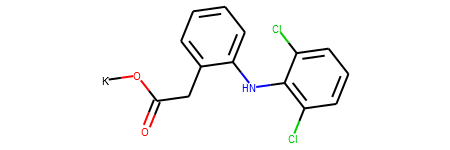

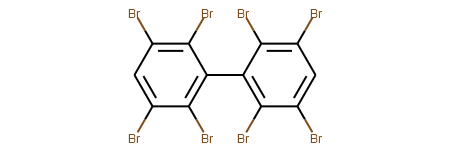

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

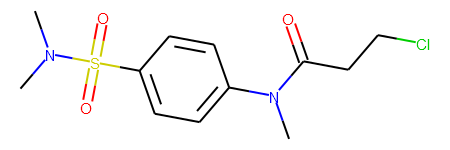

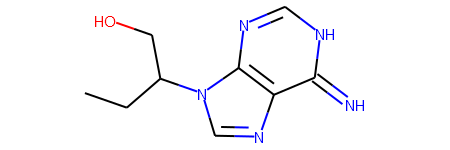

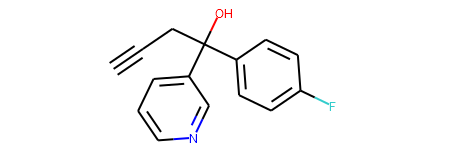

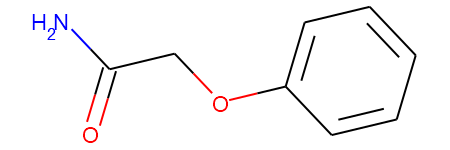

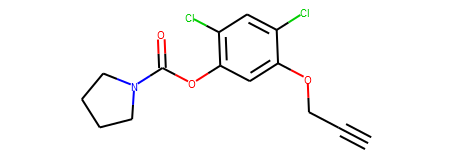

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1186,CN(C(=O)CCCl)c1ccc(S(=O)(=O)N(C)C)cc1,0.98,0.980007,5.184000e-11,17,2,2,11.764706,0,0.0,19,6,31.578947,False
1089,CCC(CO)n1cnc2c(=N)[nH]cnc21,0.14,0.139901,9.725904e-09,13,1,1,7.692308,1,100.0,16,10,62.500000,False
1312,C#CCC(O)(c1ccc(F)cc1)c1cccnc1,1.78,1.780633,4.009422e-07,27,4,1,3.703704,2,50.0,19,12,63.157895,False
865,NC(=O)COc1ccccc1,0.76,0.759117,7.795654e-07,26,2,1,3.846154,1,50.0,11,6,54.545455,False
1227,C#CCOc1cc(OC(=O)N2CCCC2)c(Cl)cc1Cl,3.82,3.819049,9.036404e-07,13,1,0,0.000000,1,100.0,21,6,28.571429,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.00000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.113214,2.113938,4.578645e-03,16.348653,1.66878,0.893819,5.883874,0.887480,52.876387,16.702060,7.437401,45.815487
std,1.756113,1.753779,4.369375e-03,6.804445,1.08509,1.375457,9.348225,0.773583,42.465858,7.148314,4.206434,22.917672
min,-3.170000,-3.205177,5.184000e-11,5.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.950000,0.954194,7.436794e-04,11.000000,1.00000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,1.960000,1.923904,2.951358e-03,16.000000,1.00000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,48.000000
75%,3.135000,3.131145,7.859408e-03,20.000000,2.00000,1.000000,8.333333,1.000000,100.000000,20.000000,11.000000,60.000000
max,8.200000,8.185325,1.450986e-02,57.000000,8.00000,9.000000,80.000000,6.000000,100.000000,64.000000,26.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.991553,1.971689,0.044755,16.870048,1.711569,0.862124,5.608677,0.889065,53.339937,16.602219,6.949287,42.486304
std,1.690116,1.668921,0.021399,7.714483,1.152985,1.373794,9.507736,0.780958,42.822242,7.374253,4.463677,25.308959
min,-2.780000,-2.971633,0.014581,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.770000,0.829325,0.026690,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.500000,6.000000,28.991597
50%,1.800000,1.838193,0.041495,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,44.444444
75%,2.945000,2.889028,0.060396,20.000000,2.000000,1.000000,8.333333,1.000000,100.000000,20.000000,11.000000,60.000000
max,7.910000,7.653224,0.091270,85.000000,8.000000,9.000000,60.000000,5.000000,100.000000,55.000000,27.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.008097,1.964323,0.777644,16.216772,1.655063,0.862342,5.566194,0.841772,51.147152,18.147152,7.281646,41.183088
std,1.984022,1.996055,9.178173,6.518692,1.052357,1.274537,8.269680,0.757610,42.893127,8.730815,4.846923,24.778466
min,-3.890000,-4.089780,0.091788,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.650000,0.703859,0.143146,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.750000,6.000000,27.272727
50%,1.840000,1.852062,0.224153,15.000000,1.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.000000,42.857143
75%,3.307500,3.067520,0.438154,20.000000,2.000000,1.000000,9.090909,1.000000,100.000000,22.000000,11.000000,60.000000
max,9.050000,16.529467,230.112729,54.000000,8.000000,8.000000,71.428571,5.000000,100.000000,88.000000,27.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CN(C(=O)CCCl)c1ccc(S(=O)(=O)N(C)C)cc1,0.98,0.980007,5.184000e-11,17,2,2,11.764706,0,0.0,19,6,31.578947,False
1,CCC(CO)n1cnc2c(=N)[nH]cnc21,0.14,0.139901,9.725904e-09,13,1,1,7.692308,1,100.0,16,10,62.500000,False
2,C#CCC(O)(c1ccc(F)cc1)c1cccnc1,1.78,1.780633,4.009422e-07,27,4,1,3.703704,2,50.0,19,12,63.157895,False
3,NC(=O)COc1ccccc1,0.76,0.759117,7.795654e-07,26,2,1,3.846154,1,50.0,11,6,54.545455,False
4,C#CCOc1cc(OC(=O)N2CCCC2)c(Cl)cc1Cl,3.82,3.819049,9.036404e-07,13,1,0,0.000000,1,100.0,21,6,28.571429,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

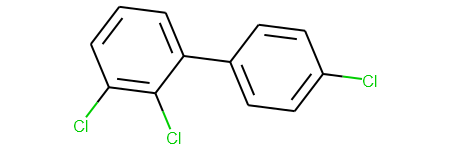

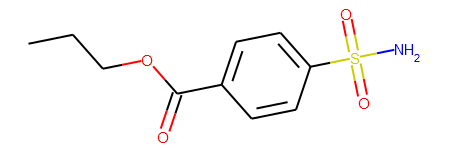

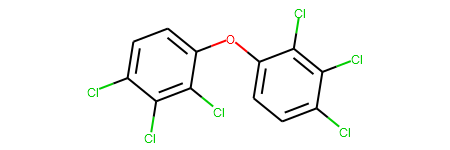

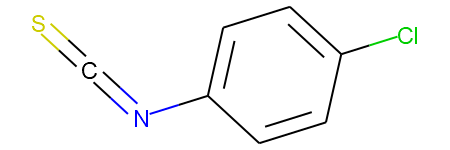

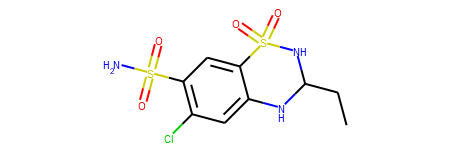

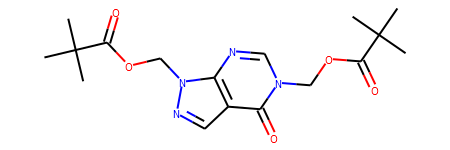

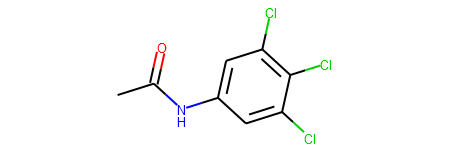

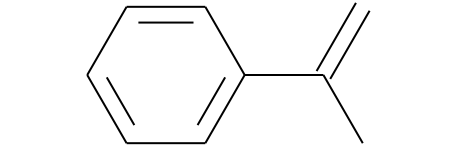

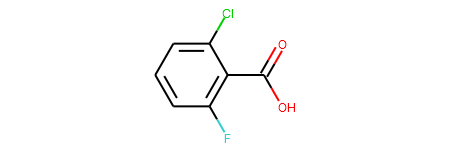

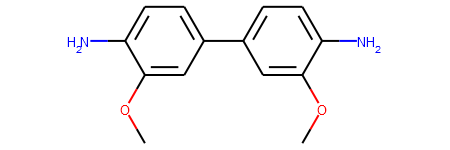

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CCOC(=O)NC1=NCC(c2cccc(C)c2C)N1C,2.57,2.449250,0.014581,15,1,0,0.000000,1,100.000000,21,6,28.571429,False
1,CNC12CCCCC1CSc1ccccc12,3.88,3.758965,0.014649,16,2,0,0.000000,1,50.000000,18,6,33.333333,False
2,CN(C)N=Nc1ccc(S(=O)(=O)CCO)cc1,1.15,1.028135,0.014851,9,2,0,0.000000,1,50.000000,17,6,35.294118,False
3,N=c1[nH]nc(CCc2ccccc2)o1,1.19,1.068082,0.014864,21,3,1,4.761905,2,66.666667,15,11,73.333333,False
4,NC(=O)c1cccnc1,-0.37,-0.247304,0.015054,23,3,1,4.347826,2,66.666667,9,6,66.666667,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

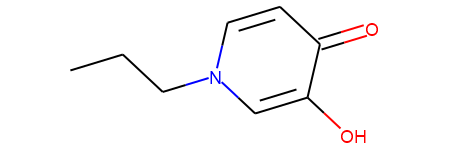

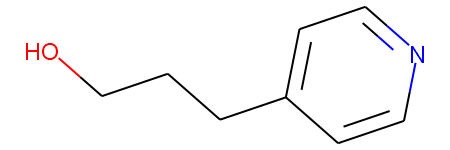

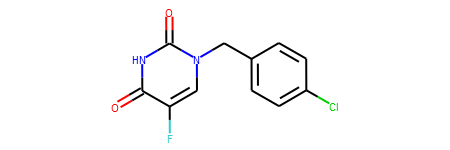

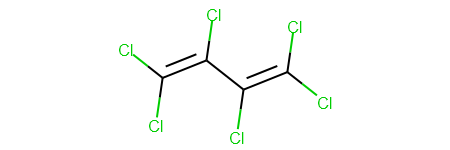

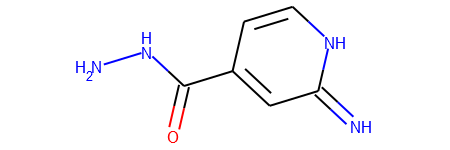

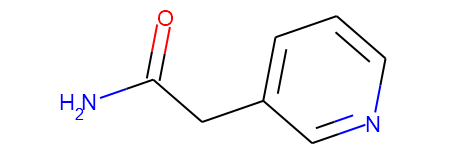

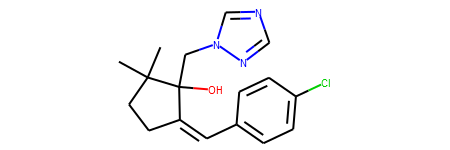

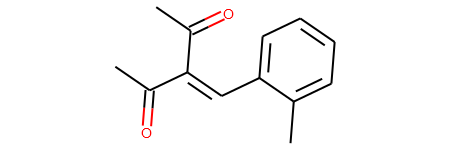

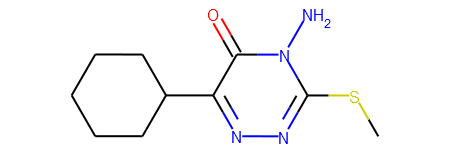

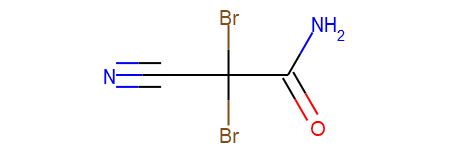

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

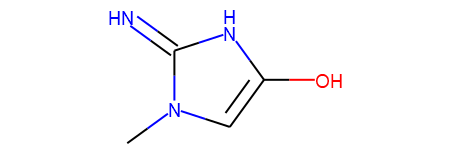

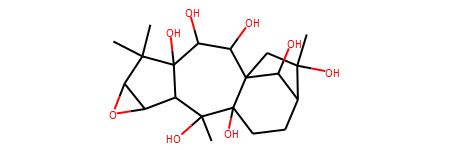

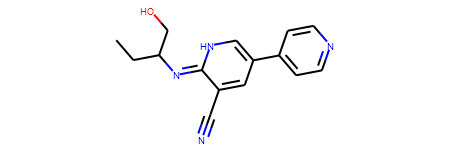

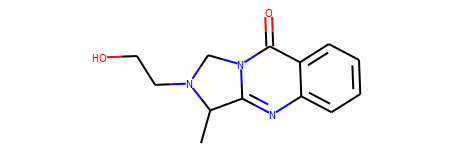

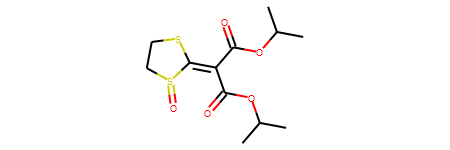

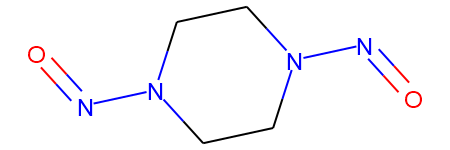

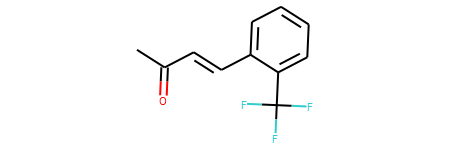

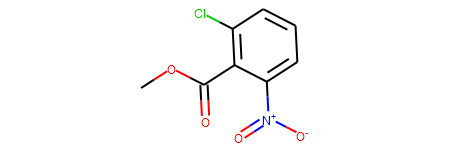

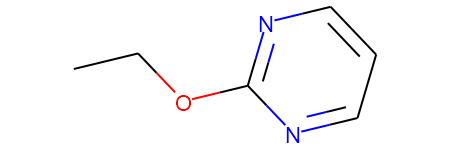

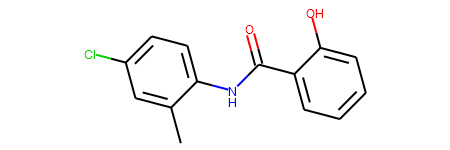

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1186,CN(C(=O)CCCl)c1ccc(S(=O)(=O)N(C)C)cc1,0.98,0.980007,5.184000e-11,17,2,2,11.764706,0,0.0,19,6,31.578947,False
1089,CCC(CO)n1cnc2c(=N)[nH]cnc21,0.14,0.139901,9.725904e-09,13,1,1,7.692308,1,100.0,16,10,62.500000,False
1312,C#CCC(O)(c1ccc(F)cc1)c1cccnc1,1.78,1.780633,4.009422e-07,27,4,1,3.703704,2,50.0,19,12,63.157895,False
865,NC(=O)COc1ccccc1,0.76,0.759117,7.795654e-07,26,2,1,3.846154,1,50.0,11,6,54.545455,False
1227,C#CCOc1cc(OC(=O)N2CCCC2)c(Cl)cc1Cl,3.82,3.819049,9.036404e-07,13,1,0,0.000000,1,100.0,21,6,28.571429,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,16.529467,230.112729,16,2,1,6.250000,1,50.0,88,24,27.272727,True
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.167287,19.073198,16,2,1,6.250000,0,0.0,20,12,60.000000,False
762,O=C(Nc1ccccc1)c1c(O)[nH]c(=S)[nH]c1=O,0.14,2.296128,4.648886,18,1,0,0.000000,0,0.0,19,12,63.157895,False
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,2.511837,3.466436,19,2,2,10.526316,2,100.0,21,12,57.142857,False
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,7.293395,3.216266,19,1,0,0.000000,0,0.0,21,12,57.142857,True


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.00000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000
mean,2.213317,2.213571,3.747768e-04,16.460000,1.635000,0.90500,5.353167,0.945000,57.75000,16.370000,7.235000,45.856380
std,1.648213,1.649298,3.712650e-04,6.364822,1.047502,1.49907,8.600787,0.809476,41.89227,6.769953,3.912328,21.365466
min,-2.280000,-2.298271,5.184000e-11,6.000000,0.000000,0.00000,0.000000,0.000000,0.00000,4.000000,0.000000,0.000000
25%,1.177500,1.170764,6.729416e-05,12.000000,1.000000,0.00000,0.000000,0.000000,0.00000,11.750000,6.000000,33.333333
50%,1.985000,1.966948,2.150843e-04,16.000000,1.000000,0.00000,0.000000,1.000000,50.00000,16.000000,6.000000,46.153846
75%,3.132500,3.132794,6.818923e-04,20.000000,2.000000,1.00000,7.410882,1.000000,100.00000,19.000000,10.000000,60.000000
max,8.200000,8.185325,1.200207e-03,47.000000,8.000000,9.00000,42.857143,6.000000,100.00000,44.000000,26.000000,100.000000


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.082813,2.087302,2.058434,16.430000,1.760000,0.835000,5.168372,0.825000,48.250000,19.900000,7.925000,41.978622
std,2.129910,2.238372,16.269169,6.947405,1.094711,1.294664,7.849625,0.711976,41.685507,10.551144,5.303775,25.550949
min,-3.700000,-3.908886,0.372096,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.620000,0.951216,0.463638,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,26.976285
50%,1.870000,1.993419,0.623649,15.500000,2.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,42.857143
75%,3.587500,3.176912,0.976727,19.250000,2.000000,1.000000,8.333333,1.000000,100.000000,24.000000,12.000000,60.000000
max,9.050000,16.529467,230.112729,49.000000,6.000000,6.000000,31.578947,3.000000,100.000000,88.000000,24.000000,92.307692


### Check atom_count influence

In [42]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=0.04502825051296124, pvalue=0.9641073742777309)


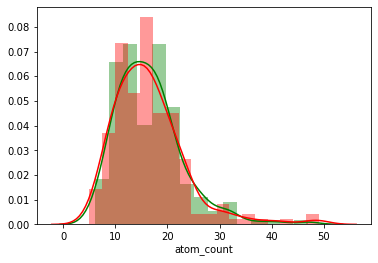

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-1.1667340277951674, pvalue=0.2440163915464553)


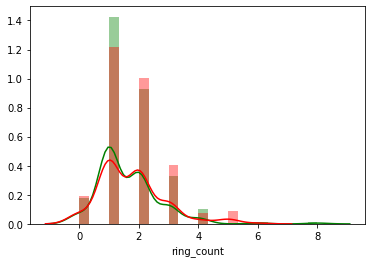

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.49978541665011195, pvalue=0.6175023694644056)


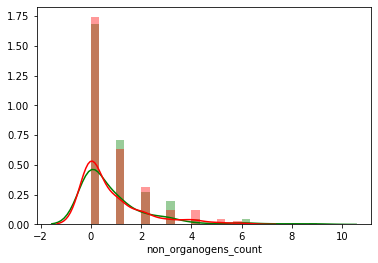

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.kruskal(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=0.22443508903646206, pvalue=0.8225339428816543)


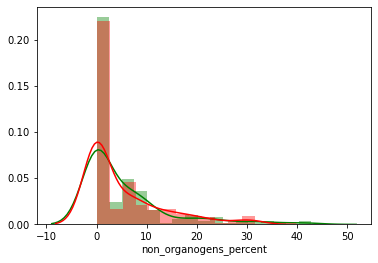

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=1.5742116855508639, pvalue=0.11623306385422949)


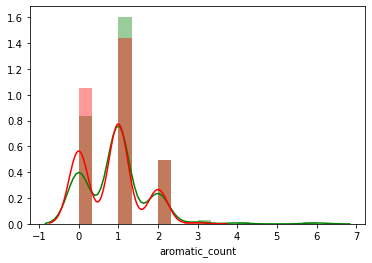

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=2.273324627029629, pvalue=0.023538775318375713)


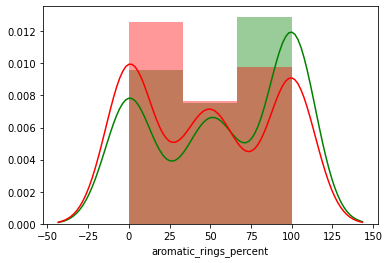

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=1.6465107127045049, pvalue=0.10044799731726049)


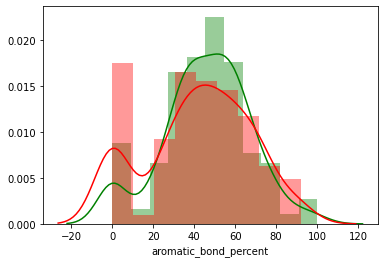

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-1.4805992269972093, pvalue=0.1395045685690098)


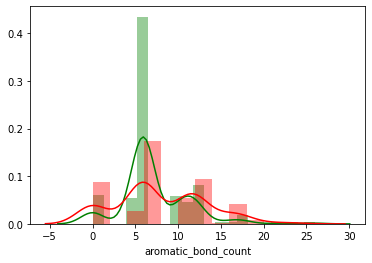

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

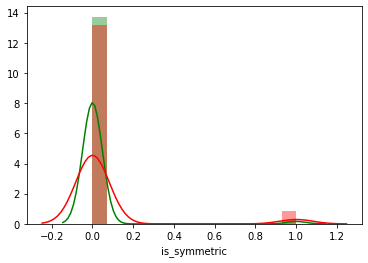

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [60]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [61]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [62]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [63]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [64]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [65]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.3745425532235729
Test symmetric R2-score is 0.9588246395482057


In [66]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.531836025534976
Test not symmetric R2-score is 0.9137591169306349
